<a href="https://colab.research.google.com/github/Madhukiranchiti/RTML-trial/blob/main/MLP_Assignment_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 1: Fashion and Housing Multi-layer Perceptron Model Training
## Course : Real-Time Machine Learning - ECGR 5106
### Name : Madhu Kiran Rao Chiti
### Student ID : 801333676
### Date : 01/26/2024


In [4]:
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, Subset

from torchvision import transforms, datasets
!pip install torchmetrics
from torchmetrics.classification import MulticlassAccuracy, BinaryAccuracy
from torchmetrics import ConfusionMatrix

import copy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 10.3 MB/s eta 0:00:00


In [5]:
class Train_Model: # A class to train and save the developed model and the metrics


    def __init__(self, model, loss, optimizer, accuracy, model_type, device, classes=0):

        self.device = device
        self.model = model.to(device) ## Setting the model on GPU
        self.Loss_Function = loss
        self.optimizer = optimizer
        self.accuracy = accuracy
        self.model_type = model_type
        self.classNum = classes

        # A dictionary to append or store the results
        self.Metrics = {"Training_Loss":[],"Training_Accuracy":[], "Validation_Loss":[], "Validation_Accuracy":[],"Test_Accuracy":0}
        self.ConfMatrix = None

    # Function to train the model
    def model_run(self, l_data,run_type):

        if run_type == 'train':
          self.model.train()

          if self.model_type == "Classification":
              MCA = self.accuracy(self.classNum)
          else:
              MCA = self.accuracy

          loss_sum = 0
          acc = 0

          # Iterates over the data
          for data, labels in tqdm(l_data):

              # transform data into one-hot vectors
              data = data.to(self.device)
              if self.model_type == "Classification":
                  labels = torch.eye(10)[labels]
              else:
                  labels = labels.reshape(-1, 1)
              labels = labels.to(self.device)

              predictions = self.model(data)
              loss_value = self.Loss_Function(predictions, labels)


              self.optimizer.zero_grad()
              loss_value.backward()
              self.optimizer.step()


              # Set the predictions and labels back into integers for accuracy calculation
              if self.model_type == "Classification":
                  predictions = torch.Tensor([torch.argmax(i).item() for i in predictions])
                  labels = torch.Tensor([torch.argmax(i).item() for i in labels])

              ##### Calculate Loss and accuracy
              loss_sum += loss_value.item()
              if self.model_type == "Classification":
                  acc += MCA(predictions, labels)

          self.Metrics["Training_Loss"].append(loss_sum / len(l_data))
          if self.model_type == "Classification":
              self.Metrics["Training_Accuracy"].append(acc / len(l_data))


        elif run_type == 'eval':
          self.model.eval()

          if self.model_type == "Classification":
              MCA = self.accuracy(self.classNum)
          else:
              MCA = self.accuracy

          loss_sum = 0
          acc = 0

          for data, labels in l_data:

              data = data.to(self.device)
              if self.model_type == "Classification":
                  labels = torch.eye(10)[labels]
              else:
                  labels = labels.reshape(-1, 1)
              labels = labels.to(self.device)

              with torch.no_grad():
                  predictions = self.model(data)
              loss_value = self.Loss_Function(predictions, labels)

              if self.model_type == "Classification":
                  predictions = torch.Tensor([torch.argmax(i).item() for i in predictions])
                  labels = torch.Tensor([torch.argmax(i).item() for i in labels])

              loss_sum += loss_value.item()
              if self.model_type == "Classification":
                  acc += MCA(predictions, labels)

          self.Metrics["Validation_Loss"].append(loss_sum / len(l_data))
          if self.model_type == "Classification":
              self.Metrics["Validation_Accuracy"].append(acc / len(l_data))


    def fit(self, t_data, v_data, EPOCHS):


        for i in range(EPOCHS):

            self.model_run(v_data,'eval')
            self.model_run(t_data,'train')

            print("Current Epoch:", i+1)
            print("Training_Loss:", self.Metrics["Training_Loss"][-1], " | Validation_Loss:", self.Metrics["Validation_Loss"][-1])
            if self.model_type == "Classification":
                print("Training_Accuracy:", self.Metrics["Training_Accuracy"][-1].item(), " | Validation_Accuracy:", self.Metrics["Validation_Accuracy"][-1].item())


    def Test_Model(self, testLoader):

        self.model.eval()

        if self.model_type == "Classification":
            confusion = ConfusionMatrix(task="multiclass", num_classes=self.classNum)
            MCA = self.accuracy(self.classNum)
        else:
            MCA = self.accuracy

        predMax = torch.empty(0)
        labelMax = torch.empty(0)

        for data, labels in testLoader:

            data = data.to(self.device)
            if self.model_type == "Classification":
                labels = torch.eye(10)[labels]
            else:
                labels = labels.reshape(-1, 1)
            labels = labels.to(self.device)

            with torch.no_grad():
                pred = self.model(data)

            if self.model_type == "Classification":
                pred = torch.Tensor([torch.argmax(i).item() for i in pred])
                labels = torch.Tensor([torch.argmax(i).item() for i in labels])

            predMax = torch.cat((predMax, pred))
            labelMax = torch.cat((labelMax, labels))

        if self.model_type == "Classification":
            self.ConfMatrix = confusion(predMax, labelMax)
            self.Metrics["Test_Accuracy"] = MCA(predMax, labelMax).item()




## Problem 1 Fashion Dataset

In [6]:
device_to_use = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
train_transform = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.29), (0.32)),
])

test_transform = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.29), (0.32)),
])

In [8]:
train_df = datasets.FashionMNIST(root="datasets", train=True, transform=train_transform,download=True)
test_df = datasets.FashionMNIST(root="datasets", train=False, transform=test_transform,download=True)

## Create Train and Test data
validNum = int(len(train_df) * 0.8)
train_df, valid_df = random_split(train_df, [validNum, len(train_df) - validNum])


100%|██████████| 26421880/26421880 [00:02<00:00, 11184915.65it/s]


Extracting datasets/FashionMNIST/raw/train-images-idx3-ubyte.gz to datasets/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 198208.81it/s]


Extracting datasets/FashionMNIST/raw/train-labels-idx1-ubyte.gz to datasets/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3692643.04it/s]


Extracting datasets/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to datasets/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 22728712.62it/s]

Extracting datasets/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/FashionMNIST/raw



In [9]:
trainLoader = DataLoader(train_df, batch_size=256, shuffle=True, num_workers=1)
validateLoader = DataLoader(valid_df, batch_size=256, shuffle=True, num_workers=1)
testLoader = DataLoader(test_df, batch_size=256, shuffle=True, num_workers=1)

In [10]:
BaseModel = nn.Sequential(
    nn.Flatten(),
    nn.LazyLinear(256),
    nn.ReLU(),
    nn.Linear(in_features= 256, out_features= 128),
    nn.ReLU(),
    nn.Linear(in_features= 128, out_features= 64),
    nn.ReLU(),
    nn.Linear(in_features= 64, out_features= 10),
)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [11]:
base = copy.deepcopy(BaseModel)
baseline_model_generator = Train_Model(base, nn.CrossEntropyLoss(), torch.optim.SGD(base.parameters(), lr=0.01, momentum=0.9), MulticlassAccuracy, "Classification",  device_to_use, 10)

### 1.a Train the model from scratch (with randomized parameters)

100%|██████████| 188/188 [00:21<00:00,  8.94it/s]

Current Epoch: 1
Training_Loss: 1.0500505211505484  | Validation_Loss: 2.3084451797160694
Training_Accuracy: 0.636378824710846  | Validation_Accuracy: 0.08091837912797928



100%|██████████| 188/188 [00:13<00:00, 14.43it/s]

Current Epoch: 2
Training_Loss: 0.4836652748128201  | Validation_Loss: 0.5452759411740811
Training_Accuracy: 0.8268733024597168  | Validation_Accuracy: 0.8023600578308105



100%|██████████| 188/188 [00:12<00:00, 14.98it/s]

Current Epoch: 3
Training_Loss: 0.4204167959854958  | Validation_Loss: 0.4526732278631089
Training_Accuracy: 0.8486995100975037  | Validation_Accuracy: 0.8332858681678772



100%|██████████| 188/188 [00:12<00:00, 14.97it/s]

Current Epoch: 4
Training_Loss: 0.37867311356549566  | Validation_Loss: 0.41675850431969824
Training_Accuracy: 0.8612500429153442  | Validation_Accuracy: 0.8468869924545288



100%|██████████| 188/188 [00:12<00:00, 14.99it/s]

Current Epoch: 5
Training_Loss: 0.3568006906103581  | Validation_Loss: 0.3739320071453744
Training_Accuracy: 0.8704100251197815  | Validation_Accuracy: 0.8655644655227661



100%|██████████| 188/188 [00:13<00:00, 13.47it/s]

Current Epoch: 6
Training_Loss: 0.3320544681492004  | Validation_Loss: 0.3561063072782882
Training_Accuracy: 0.8785456418991089  | Validation_Accuracy: 0.8729470372200012



100%|██████████| 188/188 [00:12<00:00, 14.90it/s]

Current Epoch: 7
Training_Loss: 0.3171844224029399  | Validation_Loss: 0.3421236901207173
Training_Accuracy: 0.8841915726661682  | Validation_Accuracy: 0.8768923878669739



100%|██████████| 188/188 [00:13<00:00, 14.06it/s]

Current Epoch: 8
Training_Loss: 0.30526228344186823  | Validation_Loss: 0.3433561122163813
Training_Accuracy: 0.8881681561470032  | Validation_Accuracy: 0.8755654692649841



100%|██████████| 188/188 [00:12<00:00, 14.66it/s]

Current Epoch: 9
Training_Loss: 0.28764414922037024  | Validation_Loss: 0.33325594663619995
Training_Accuracy: 0.8940999507904053  | Validation_Accuracy: 0.8782463669776917



100%|██████████| 188/188 [00:12<00:00, 14.54it/s]

Current Epoch: 10
Training_Loss: 0.27412207614868245  | Validation_Loss: 0.34198071886884407
Training_Accuracy: 0.8993554711341858  | Validation_Accuracy: 0.8755952715873718



100%|██████████| 188/188 [00:12<00:00, 14.50it/s]

Current Epoch: 11
Training_Loss: 0.26313076461566254  | Validation_Loss: 0.32514677719866975
Training_Accuracy: 0.9027085900306702  | Validation_Accuracy: 0.8826819658279419



100%|██████████| 188/188 [00:13<00:00, 14.37it/s]

Current Epoch: 12
Training_Loss: 0.2559812489817751  | Validation_Loss: 0.32092379699362084
Training_Accuracy: 0.9047555923461914  | Validation_Accuracy: 0.8837547302246094



100%|██████████| 188/188 [00:12<00:00, 14.74it/s]

Current Epoch: 13
Training_Loss: 0.24674118357769986  | Validation_Loss: 0.32514201770437523
Training_Accuracy: 0.9087772965431213  | Validation_Accuracy: 0.8819292187690735



100%|██████████| 188/188 [00:18<00:00, 10.03it/s]

Current Epoch: 14
Training_Loss: 0.2332844412390222  | Validation_Loss: 0.3031341557173019
Training_Accuracy: 0.9148054122924805  | Validation_Accuracy: 0.8922213912010193



100%|██████████| 188/188 [00:12<00:00, 14.76it/s]

Current Epoch: 15
Training_Loss: 0.22926086647079347  | Validation_Loss: 0.34381566814919734
Training_Accuracy: 0.9145690202713013  | Validation_Accuracy: 0.8780847787857056



100%|██████████| 188/188 [00:12<00:00, 14.70it/s]

Current Epoch: 16
Training_Loss: 0.22041493170755974  | Validation_Loss: 0.326368843621396
Training_Accuracy: 0.9192352890968323  | Validation_Accuracy: 0.8833059668540955



100%|██████████| 188/188 [00:12<00:00, 14.96it/s]

Current Epoch: 17
Training_Loss: 0.20963184955589315  | Validation_Loss: 0.3081276334346609
Training_Accuracy: 0.922264814376831  | Validation_Accuracy: 0.8906387686729431



100%|██████████| 188/188 [00:14<00:00, 12.59it/s]

Current Epoch: 18
Training_Loss: 0.20254618515993686  | Validation_Loss: 0.3075667717989455
Training_Accuracy: 0.9241777658462524  | Validation_Accuracy: 0.8913213014602661



100%|██████████| 188/188 [00:14<00:00, 13.40it/s]

Current Epoch: 19
Training_Loss: 0.19610650655119977  | Validation_Loss: 0.30238597063308065
Training_Accuracy: 0.9263246655464172  | Validation_Accuracy: 0.8931156992912292



100%|██████████| 188/188 [00:14<00:00, 13.20it/s]

Current Epoch: 20
Training_Loss: 0.19086758752769611  | Validation_Loss: 0.312889630173115
Training_Accuracy: 0.9304797649383545  | Validation_Accuracy: 0.8937328457832336



Test Accuracy: 0.8826999664306641 
Time to Train: 0:05:42.375688


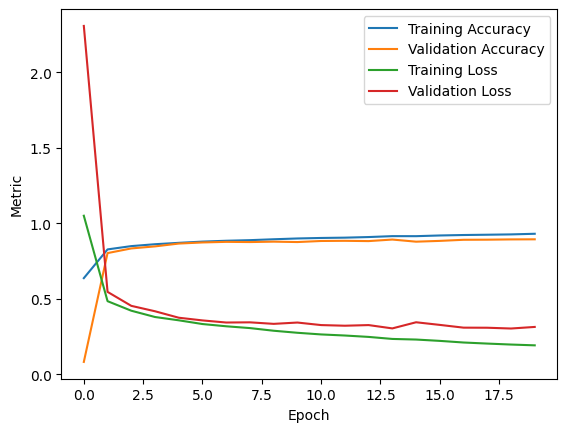

In [12]:
start_time = datetime.now()

baseline_model_generator.fit(trainLoader, validateLoader,
                             20)
end_time = datetime.now()
baseline_model_generator.Test_Model(testLoader)

print("\nTest Accuracy:", baseline_model_generator.Metrics["Test_Accuracy"], "\nTime to Train:", end_time - start_time)
import matplotlib.pyplot as plt

### PLOTTING METRICS
plt.plot(baseline_model_generator.Metrics['Training_Accuracy'], label='Training Accuracy')
plt.plot(baseline_model_generator.Metrics['Validation_Accuracy'], label='Validation Accuracy')
plt.plot(baseline_model_generator.Metrics['Training_Loss'], label='Training Loss')
plt.plot(baseline_model_generator.Metrics['Validation_Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()

100%|██████████| 188/188 [00:15<00:00, 12.23it/s]

Current Epoch: 1
Training_Loss: 0.1809726703436451  | Validation_Loss: 0.3033023863396746
Training_Accuracy: 0.9335700273513794  | Validation_Accuracy: 0.8939234018325806



100%|██████████| 188/188 [00:13<00:00, 14.13it/s]

Current Epoch: 2
Training_Loss: 0.18071191710360507  | Validation_Loss: 0.317777490045162
Training_Accuracy: 0.9327509999275208  | Validation_Accuracy: 0.8907788991928101



100%|██████████| 188/188 [00:13<00:00, 13.95it/s]

Current Epoch: 3
Training_Loss: 0.16464895188332873  | Validation_Loss: 0.3094804023808621
Training_Accuracy: 0.9398093819618225  | Validation_Accuracy: 0.8937069773674011



100%|██████████| 188/188 [00:13<00:00, 14.13it/s]

Current Epoch: 4
Training_Loss: 0.15890358756989875  | Validation_Loss: 0.32657999973347845
Training_Accuracy: 0.9408702254295349  | Validation_Accuracy: 0.8914366960525513



100%|██████████| 188/188 [00:13<00:00, 13.77it/s]

Current Epoch: 5
Training_Loss: 0.1556253779203968  | Validation_Loss: 0.3193051666021347
Training_Accuracy: 0.9422858357429504  | Validation_Accuracy: 0.8908627033233643



100%|██████████| 188/188 [00:15<00:00, 12.53it/s]

Current Epoch: 6
Training_Loss: 0.1490257636425977  | Validation_Loss: 0.3380328232937671
Training_Accuracy: 0.9455470442771912  | Validation_Accuracy: 0.8909894824028015



100%|██████████| 188/188 [00:13<00:00, 14.33it/s]

Current Epoch: 7
Training_Loss: 0.14236568370239533  | Validation_Loss: 0.31840253637192095
Training_Accuracy: 0.9468644261360168  | Validation_Accuracy: 0.8960145711898804



100%|██████████| 188/188 [00:13<00:00, 13.55it/s]

Current Epoch: 8
Training_Loss: 0.13823444534965018  | Validation_Loss: 0.3642257147646965
Training_Accuracy: 0.9483682513237  | Validation_Accuracy: 0.8862104415893555



100%|██████████| 188/188 [00:12<00:00, 14.71it/s]

Current Epoch: 9
Training_Loss: 0.13602378449224412  | Validation_Loss: 0.3397374707967677
Training_Accuracy: 0.9503324627876282  | Validation_Accuracy: 0.8948918581008911



100%|██████████| 188/188 [00:13<00:00, 14.11it/s]

Current Epoch: 10
Training_Loss: 0.13275268479706126  | Validation_Loss: 0.345040555012987
Training_Accuracy: 0.9510816931724548  | Validation_Accuracy: 0.8917220830917358



100%|██████████| 188/188 [00:13<00:00, 13.99it/s]


Current Epoch: 11
Training_Loss: 0.1226939578005608  | Validation_Loss: 0.3487951929898972
Training_Accuracy: 0.9555431008338928  | Validation_Accuracy: 0.8946571350097656


100%|██████████| 188/188 [00:13<00:00, 14.06it/s]

Current Epoch: 12
Training_Loss: 0.11958431692278766  | Validation_Loss: 0.3334254501981938
Training_Accuracy: 0.9554371237754822  | Validation_Accuracy: 0.8960800766944885



100%|██████████| 188/188 [00:12<00:00, 14.55it/s]

Current Epoch: 13
Training_Loss: 0.11980398189514241  | Validation_Loss: 0.37024455279745955
Training_Accuracy: 0.9559851288795471  | Validation_Accuracy: 0.8849146962165833



100%|██████████| 188/188 [00:13<00:00, 14.11it/s]

Current Epoch: 14
Training_Loss: 0.1133227393704843  | Validation_Loss: 0.36984242276942475
Training_Accuracy: 0.9567206501960754  | Validation_Accuracy: 0.8907378911972046



100%|██████████| 188/188 [00:13<00:00, 14.36it/s]

Current Epoch: 15
Training_Loss: 0.10367380044958059  | Validation_Loss: 0.37080233877009533
Training_Accuracy: 0.9616285562515259  | Validation_Accuracy: 0.8935004472732544



100%|██████████| 188/188 [00:13<00:00, 13.81it/s]

Current Epoch: 16
Training_Loss: 0.10388097234387347  | Validation_Loss: 0.37247473096593897
Training_Accuracy: 0.9617062211036682  | Validation_Accuracy: 0.8912584185600281



100%|██████████| 188/188 [00:13<00:00, 13.84it/s]

Current Epoch: 17
Training_Loss: 0.09664373573391362  | Validation_Loss: 0.36650253768931046
Training_Accuracy: 0.9639256000518799  | Validation_Accuracy: 0.8962377905845642



100%|██████████| 188/188 [00:13<00:00, 14.33it/s]

Current Epoch: 18
Training_Loss: 0.09682430943196758  | Validation_Loss: 0.39243352349768296
Training_Accuracy: 0.9649198055267334  | Validation_Accuracy: 0.8911001086235046



100%|██████████| 188/188 [00:13<00:00, 13.86it/s]

Current Epoch: 19
Training_Loss: 0.09197564958099355  | Validation_Loss: 0.3956682856412644
Training_Accuracy: 0.965857982635498  | Validation_Accuracy: 0.8943367004394531



100%|██████████| 188/188 [00:14<00:00, 13.06it/s]

Current Epoch: 20
Training_Loss: 0.08947382972357755  | Validation_Loss: 0.38708247529699447
Training_Accuracy: 0.9666922688484192  | Validation_Accuracy: 0.8919593095779419



100%|██████████| 188/188 [00:13<00:00, 13.67it/s]

Current Epoch: 21
Training_Loss: 0.08278187576364329  | Validation_Loss: 0.3960548566376909
Training_Accuracy: 0.9689980149269104  | Validation_Accuracy: 0.8908399939537048



100%|██████████| 188/188 [00:13<00:00, 14.07it/s]

Current Epoch: 22
Training_Loss: 0.07838058107076808  | Validation_Loss: 0.4367739957697848
Training_Accuracy: 0.9701869487762451  | Validation_Accuracy: 0.8848670721054077



100%|██████████| 188/188 [00:14<00:00, 13.03it/s]

Current Epoch: 23
Training_Loss: 0.07924981956231467  | Validation_Loss: 0.42073787241540056
Training_Accuracy: 0.9709526896476746  | Validation_Accuracy: 0.893690824508667



100%|██████████| 188/188 [00:13<00:00, 13.98it/s]


Current Epoch: 24
Training_Loss: 0.07628236964662025  | Validation_Loss: 0.4126575620884591
Training_Accuracy: 0.9721526503562927  | Validation_Accuracy: 0.8938025832176208


100%|██████████| 188/188 [00:13<00:00, 14.35it/s]

Current Epoch: 25
Training_Loss: 0.07235807400355314  | Validation_Loss: 0.46221924779262946
Training_Accuracy: 0.9734059572219849  | Validation_Accuracy: 0.8882336020469666



Test Accuracy: 0.8823999762535095 
Time to Train: 0:07:01.049343


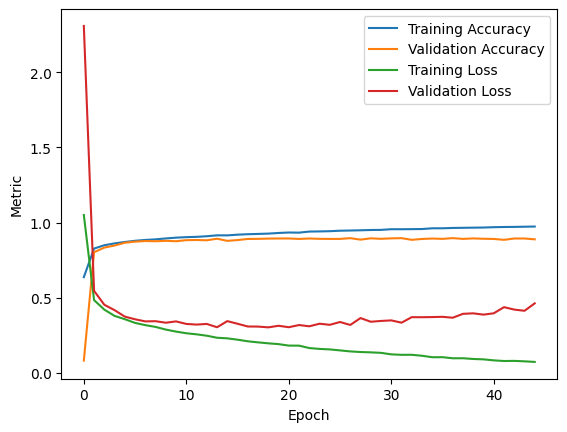

In [13]:
start_time = datetime.now()

baseline_model_generator.fit(trainLoader, validateLoader,
                             25)
end_time = datetime.now()
baseline_model_generator.Test_Model(testLoader)

print("\nTest Accuracy:", baseline_model_generator.Metrics["Test_Accuracy"], "\nTime to Train:", end_time - start_time)
import matplotlib.pyplot as plt

### PLOTTING METRICS
plt.plot(baseline_model_generator.Metrics['Training_Accuracy'], label='Training Accuracy')
plt.plot(baseline_model_generator.Metrics['Validation_Accuracy'], label='Validation Accuracy')
plt.plot(baseline_model_generator.Metrics['Training_Loss'], label='Training Loss')
plt.plot(baseline_model_generator.Metrics['Validation_Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()

100%|██████████| 188/188 [00:13<00:00, 14.39it/s]


Current Epoch: 1
Training_Loss: 0.06862471000033807  | Validation_Loss: 0.4158077912127718
Training_Accuracy: 0.9758195281028748  | Validation_Accuracy: 0.8977219462394714


100%|██████████| 188/188 [00:12<00:00, 14.47it/s]

Current Epoch: 2
Training_Loss: 0.06950994688977903  | Validation_Loss: 0.47237696990053707
Training_Accuracy: 0.9743400812149048  | Validation_Accuracy: 0.8858674168586731



100%|██████████| 188/188 [00:15<00:00, 12.47it/s]

Current Epoch: 3
Training_Loss: 0.0635597323552963  | Validation_Loss: 0.45051621185972335
Training_Accuracy: 0.9769495725631714  | Validation_Accuracy: 0.8912312388420105



100%|██████████| 188/188 [00:13<00:00, 13.52it/s]

Current Epoch: 4
Training_Loss: 0.06279566222207343  | Validation_Loss: 0.46871986604751426
Training_Accuracy: 0.9765681028366089  | Validation_Accuracy: 0.891963541507721



100%|██████████| 188/188 [00:14<00:00, 13.27it/s]

Current Epoch: 5
Training_Loss: 0.06276415738257322  | Validation_Loss: 0.45184237525818194
Training_Accuracy: 0.9777907729148865  | Validation_Accuracy: 0.8952962756156921



100%|██████████| 188/188 [00:12<00:00, 14.57it/s]

Current Epoch: 6
Training_Loss: 0.06427738453915462  | Validation_Loss: 0.4638116740165873
Training_Accuracy: 0.9766905903816223  | Validation_Accuracy: 0.8939359784126282



100%|██████████| 188/188 [00:12<00:00, 14.80it/s]

Current Epoch: 7
Training_Loss: 0.059107673859738925  | Validation_Loss: 0.4623340295350298
Training_Accuracy: 0.9779746532440186  | Validation_Accuracy: 0.8943983912467957



100%|██████████| 188/188 [00:12<00:00, 15.06it/s]

Current Epoch: 8
Training_Loss: 0.06339795235544443  | Validation_Loss: 0.4713195226293929
Training_Accuracy: 0.9756757020950317  | Validation_Accuracy: 0.896654486656189



100%|██████████| 188/188 [00:12<00:00, 14.52it/s]

Current Epoch: 9
Training_Loss: 0.05345646333583492  | Validation_Loss: 0.4992150670670448
Training_Accuracy: 0.98011714220047  | Validation_Accuracy: 0.890058696269989



100%|██████████| 188/188 [00:13<00:00, 13.76it/s]

Current Epoch: 10
Training_Loss: 0.05420230579701193  | Validation_Loss: 0.4914459484688779
Training_Accuracy: 0.9795961380004883  | Validation_Accuracy: 0.8935033082962036



100%|██████████| 188/188 [00:12<00:00, 14.97it/s]

Current Epoch: 11
Training_Loss: 0.05490578975568109  | Validation_Loss: 0.5178925458421099
Training_Accuracy: 0.9800227284431458  | Validation_Accuracy: 0.8938656449317932



100%|██████████| 188/188 [00:12<00:00, 14.72it/s]

Current Epoch: 12
Training_Loss: 0.050189621474078676  | Validation_Loss: 0.5036523551382917
Training_Accuracy: 0.981413722038269  | Validation_Accuracy: 0.895172119140625



100%|██████████| 188/188 [00:12<00:00, 14.76it/s]

Current Epoch: 13
Training_Loss: 0.04509608898846869  | Validation_Loss: 0.5525988410127923
Training_Accuracy: 0.9831644296646118  | Validation_Accuracy: 0.8930343389511108



100%|██████████| 188/188 [00:12<00:00, 14.80it/s]

Current Epoch: 14
Training_Loss: 0.043957868551320216  | Validation_Loss: 0.5059305175821832
Training_Accuracy: 0.9841164350509644  | Validation_Accuracy: 0.8943603038787842



100%|██████████| 188/188 [00:12<00:00, 14.78it/s]

Current Epoch: 15
Training_Loss: 0.040663524766135564  | Validation_Loss: 0.5179665925654959
Training_Accuracy: 0.9846323728561401  | Validation_Accuracy: 0.8977361917495728



100%|██████████| 188/188 [00:12<00:00, 14.79it/s]

Current Epoch: 16
Training_Loss: 0.0460521939676255  | Validation_Loss: 0.5423414726206597
Training_Accuracy: 0.9834413528442383  | Validation_Accuracy: 0.8959159255027771



100%|██████████| 188/188 [00:12<00:00, 14.57it/s]

Current Epoch: 17
Training_Loss: 0.03371979004921431  | Validation_Loss: 0.5377092361450195
Training_Accuracy: 0.9881531000137329  | Validation_Accuracy: 0.8935760259628296



100%|██████████| 188/188 [00:12<00:00, 14.64it/s]

Current Epoch: 18
Training_Loss: 0.03162786914431985  | Validation_Loss: 0.5324726459827829
Training_Accuracy: 0.9891016483306885  | Validation_Accuracy: 0.8971089124679565



100%|██████████| 188/188 [00:12<00:00, 14.93it/s]

Current Epoch: 19
Training_Loss: 0.038200103648086174  | Validation_Loss: 0.5563716000698983
Training_Accuracy: 0.9860105514526367  | Validation_Accuracy: 0.897796630859375



100%|██████████| 188/188 [00:12<00:00, 14.56it/s]

Current Epoch: 20
Training_Loss: 0.0404425830174079  | Validation_Loss: 0.5398546932859624
Training_Accuracy: 0.985499918460846  | Validation_Accuracy: 0.895305335521698



100%|██████████| 188/188 [00:12<00:00, 14.75it/s]

Current Epoch: 21
Training_Loss: 0.032355132257625305  | Validation_Loss: 0.5766850538710331
Training_Accuracy: 0.987880527973175  | Validation_Accuracy: 0.8915501832962036



100%|██████████| 188/188 [00:13<00:00, 14.44it/s]

Current Epoch: 22
Training_Loss: 0.04253177810955713  | Validation_Loss: 0.5748883301907397
Training_Accuracy: 0.9843904972076416  | Validation_Accuracy: 0.8956469893455505



100%|██████████| 188/188 [00:13<00:00, 13.94it/s]

Current Epoch: 23
Training_Loss: 0.02847154864278483  | Validation_Loss: 0.5542801041552361
Training_Accuracy: 0.9902884364128113  | Validation_Accuracy: 0.8935286402702332



100%|██████████| 188/188 [00:12<00:00, 14.72it/s]

Current Epoch: 24
Training_Loss: 0.028451970411821247  | Validation_Loss: 0.5652646688704795
Training_Accuracy: 0.9901038408279419  | Validation_Accuracy: 0.8957794904708862



100%|██████████| 188/188 [00:12<00:00, 14.56it/s]

Current Epoch: 25
Training_Loss: 0.032029784673408786  | Validation_Loss: 0.6173334850909862
Training_Accuracy: 0.9887305498123169  | Validation_Accuracy: 0.8938935995101929



100%|██████████| 188/188 [00:12<00:00, 14.78it/s]

Current Epoch: 26
Training_Loss: 0.035523438692449574  | Validation_Loss: 0.6146257513381065
Training_Accuracy: 0.9867495894432068  | Validation_Accuracy: 0.8919643759727478



100%|██████████| 188/188 [00:12<00:00, 14.96it/s]

Current Epoch: 27
Training_Loss: 0.03275464860068515  | Validation_Loss: 0.6052426099777222
Training_Accuracy: 0.9883846640586853  | Validation_Accuracy: 0.8959031701087952



100%|██████████| 188/188 [00:12<00:00, 14.76it/s]

Current Epoch: 28
Training_Loss: 0.0262009912700531  | Validation_Loss: 0.6192353989215608
Training_Accuracy: 0.9904229044914246  | Validation_Accuracy: 0.8945435285568237



100%|██████████| 188/188 [00:13<00:00, 13.76it/s]

Current Epoch: 29
Training_Loss: 0.030375073158598328  | Validation_Loss: 0.6326600040527101
Training_Accuracy: 0.9884973764419556  | Validation_Accuracy: 0.8942708969116211



100%|██████████| 188/188 [00:12<00:00, 15.11it/s]

Current Epoch: 30
Training_Loss: 0.02286217219760998  | Validation_Loss: 0.6314948296293299
Training_Accuracy: 0.9919538497924805  | Validation_Accuracy: 0.8960336446762085



Test Accuracy: 0.880899965763092 
Time to Train: 0:08:03.070318


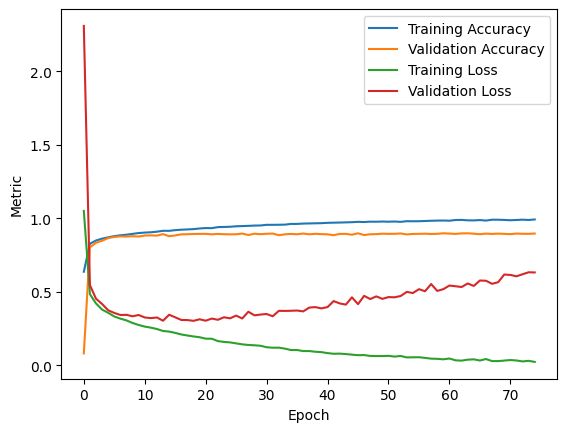

In [14]:
start_time = datetime.now()

baseline_model_generator.fit(trainLoader, validateLoader,
                             30)
end_time = datetime.now()
baseline_model_generator.Test_Model(testLoader)

print("\nTest Accuracy:", baseline_model_generator.Metrics["Test_Accuracy"], "\nTime to Train:", end_time - start_time)
import matplotlib.pyplot as plt

### PLOTTING METRICS
plt.plot(baseline_model_generator.Metrics['Training_Accuracy'], label='Training Accuracy')
plt.plot(baseline_model_generator.Metrics['Validation_Accuracy'], label='Validation Accuracy')
plt.plot(baseline_model_generator.Metrics['Training_Loss'], label='Training Loss')
plt.plot(baseline_model_generator.Metrics['Validation_Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()

### 1.b. Explore the complexity of the network by increasing its width and depth.

In [15]:
# Increased depth and width
ComplexModel = nn.Sequential(
    nn.Flatten(),
    nn.LazyLinear(512),
    nn.ReLU(),
    nn.Linear(in_features=512, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=64),
    nn.ReLU(),
    nn.Linear(in_features=64, out_features=10),
)
complex_model = copy.deepcopy(ComplexModel)


In [16]:
complex_m = copy.deepcopy(ComplexModel)
complex_model_generator = Train_Model(complex_m, nn.CrossEntropyLoss(), torch.optim.SGD(complex_m.parameters(), lr=0.01, momentum=0.9), MulticlassAccuracy, "Classification",  device_to_use, 10)

100%|██████████| 188/188 [00:12<00:00, 14.72it/s]

Current Epoch: 1
Training_Loss: 1.2969622123748699  | Validation_Loss: 2.3060094346391393
Training_Accuracy: 0.5368368029594421  | Validation_Accuracy: 0.09997232258319855



100%|██████████| 188/188 [00:12<00:00, 15.00it/s]

Current Epoch: 2
Training_Loss: 0.5119279451826786  | Validation_Loss: 0.5834566265978711
Training_Accuracy: 0.8157603740692139  | Validation_Accuracy: 0.7874643206596375



100%|██████████| 188/188 [00:12<00:00, 14.94it/s]

Current Epoch: 3
Training_Loss: 0.42036685965796733  | Validation_Loss: 0.4480235018628709
Training_Accuracy: 0.8483322858810425  | Validation_Accuracy: 0.8377759456634521



100%|██████████| 188/188 [00:12<00:00, 15.33it/s]

Current Epoch: 4
Training_Loss: 0.382845679179151  | Validation_Loss: 0.42008416259542425
Training_Accuracy: 0.8600961565971375  | Validation_Accuracy: 0.8467849493026733



100%|██████████| 188/188 [00:12<00:00, 14.73it/s]

Current Epoch: 5
Training_Loss: 0.3521334914926519  | Validation_Loss: 0.3939476539479925
Training_Accuracy: 0.8726216554641724  | Validation_Accuracy: 0.8612791895866394



100%|██████████| 188/188 [00:12<00:00, 15.05it/s]

Current Epoch: 6
Training_Loss: 0.3287935104775936  | Validation_Loss: 0.3537948467630021
Training_Accuracy: 0.8798094987869263  | Validation_Accuracy: 0.8719392418861389



100%|██████████| 188/188 [00:12<00:00, 14.83it/s]

Current Epoch: 7
Training_Loss: 0.3065450574330827  | Validation_Loss: 0.3399177390210172
Training_Accuracy: 0.8886762857437134  | Validation_Accuracy: 0.873416006565094



100%|██████████| 188/188 [00:12<00:00, 14.89it/s]

Current Epoch: 8
Training_Loss: 0.29221307795415535  | Validation_Loss: 0.33209976839258315
Training_Accuracy: 0.8927394151687622  | Validation_Accuracy: 0.880913257598877



100%|██████████| 188/188 [00:12<00:00, 14.78it/s]

Current Epoch: 9
Training_Loss: 0.2777160422757585  | Validation_Loss: 0.3296129088452522
Training_Accuracy: 0.8986688852310181  | Validation_Accuracy: 0.8819317817687988



100%|██████████| 188/188 [00:12<00:00, 15.04it/s]

Current Epoch: 10
Training_Loss: 0.2618815023055736  | Validation_Loss: 0.31631715659131393
Training_Accuracy: 0.9043760895729065  | Validation_Accuracy: 0.8842741847038269



100%|██████████| 188/188 [00:12<00:00, 14.61it/s]

Current Epoch: 11
Training_Loss: 0.25075731418551284  | Validation_Loss: 0.3138446335462814
Training_Accuracy: 0.9082430601119995  | Validation_Accuracy: 0.8850469589233398



100%|██████████| 188/188 [00:13<00:00, 14.04it/s]

Current Epoch: 12
Training_Loss: 0.23749185575449722  | Validation_Loss: 0.3151357560715777
Training_Accuracy: 0.9121188521385193  | Validation_Accuracy: 0.8864842653274536



100%|██████████| 188/188 [00:12<00:00, 14.83it/s]

Current Epoch: 13
Training_Loss: 0.23113832741658738  | Validation_Loss: 0.3294005254481701
Training_Accuracy: 0.9150069952011108  | Validation_Accuracy: 0.87962806224823



100%|██████████| 188/188 [00:12<00:00, 15.10it/s]

Current Epoch: 14
Training_Loss: 0.21880826231171477  | Validation_Loss: 0.3141571835000464
Training_Accuracy: 0.9199613928794861  | Validation_Accuracy: 0.8892420530319214



100%|██████████| 188/188 [00:12<00:00, 14.96it/s]

Current Epoch: 15
Training_Loss: 0.21507093579845227  | Validation_Loss: 0.3085100086445504
Training_Accuracy: 0.9216829538345337  | Validation_Accuracy: 0.8915671706199646



100%|██████████| 188/188 [00:12<00:00, 15.11it/s]

Current Epoch: 16
Training_Loss: 0.2016157832868556  | Validation_Loss: 0.3277814546798138
Training_Accuracy: 0.9254218339920044  | Validation_Accuracy: 0.8837246894836426



100%|██████████| 188/188 [00:12<00:00, 14.99it/s]

Current Epoch: 17
Training_Loss: 0.18722613120174153  | Validation_Loss: 0.3175209941382104
Training_Accuracy: 0.9306109547615051  | Validation_Accuracy: 0.8874028921127319



100%|██████████| 188/188 [00:12<00:00, 14.49it/s]

Current Epoch: 18
Training_Loss: 0.1820361393087722  | Validation_Loss: 0.32968750817978637
Training_Accuracy: 0.9332740306854248  | Validation_Accuracy: 0.8891285061836243



100%|██████████| 188/188 [00:12<00:00, 14.90it/s]

Current Epoch: 19
Training_Loss: 0.175205182403009  | Validation_Loss: 0.30685147643089294
Training_Accuracy: 0.935687780380249  | Validation_Accuracy: 0.8935810923576355



100%|██████████| 188/188 [00:12<00:00, 15.13it/s]

Current Epoch: 20
Training_Loss: 0.17051110416650772  | Validation_Loss: 0.31080533088521756
Training_Accuracy: 0.936629056930542  | Validation_Accuracy: 0.8958922624588013



Test Accuracy: 0.8853000402450562 
Time to Train: 0:05:14.119473


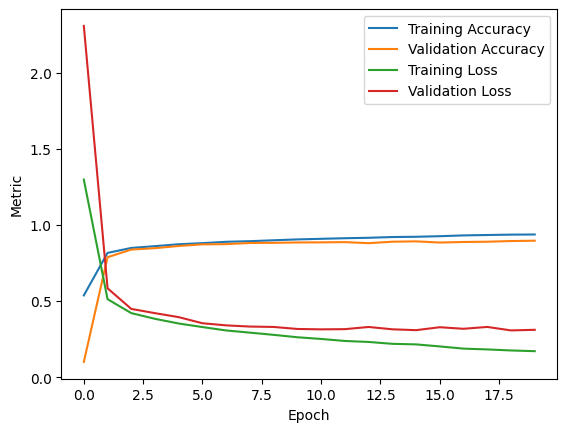

In [17]:
start_time = datetime.now()

complex_model_generator.fit(trainLoader, validateLoader,
                            20 )
end_time = datetime.now()
complex_model_generator.Test_Model(testLoader)

print("\nTest Accuracy:", complex_model_generator.Metrics["Test_Accuracy"], "\nTime to Train:", end_time - start_time)
import matplotlib.pyplot as plt

### PLOTTING METRICS
plt.plot(complex_model_generator.Metrics['Training_Accuracy'], label='Training Accuracy')
plt.plot(complex_model_generator.Metrics['Validation_Accuracy'], label='Validation Accuracy')
plt.plot(complex_model_generator.Metrics['Training_Loss'], label='Training Loss')
plt.plot(complex_model_generator.Metrics['Validation_Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()

### Does the entire training of your network require more epochs? Are you seeing any overfitting?
We observe that over the course of the 20 epochs, the training loss has decreased while the validation loss has not changed significantly. This indicates that the model is overfitting since it is doing better on the training dataset but not the validation dataset.


## Problem 2 Housing Predictions

In [18]:
device_to_use = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
train_df = pd.read_csv("/content/datasets/house-train.csv")
test_df = pd.read_csv("/content/datasets/house-test.csv")
display(train_df.head()),display(test_df.head())

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


(None, None)

In [20]:
def data_preprocessor_a(train_data, test_data, label='SalePrice'):

    features_all = pd.concat((train_data.drop(columns=['Id', label]), test_data.drop(columns=['Id'])))
    numeric_features = features_all.dtypes[features_all.dtypes != 'object'].index

    features_all[numeric_features] = features_all[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))
    features_all[numeric_features] = features_all[numeric_features].fillna(0)
    #features_all = pd.get_dummies(features_all, dummy_na=True)

    train_df = features_all[:train_data.shape[0]].copy()

    normVals = (train_data[label].mean(), train_data[label].std())
    print(normVals)

    train_df[label] = ( train_data[label] - normVals[0] ) / normVals[1]
    test_df = features_all[train_data.shape[0]:].copy()

    return train_df, test_df




In [21]:
def data_preprocessor_b(train_data, test_data, label='SalePrice'):

    features_all = pd.concat((train_data.drop(columns=['Id', label]), test_data.drop(columns=['Id'])))
    numeric_features = features_all.dtypes[features_all.dtypes != 'object'].index

    features_all[numeric_features] = features_all[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))
    features_all[numeric_features] = features_all[numeric_features].fillna(0)
    features_all = pd.get_dummies(features_all, dummy_na=True)

    train_df = features_all[:train_data.shape[0]].copy()

    normVals = (train_data[label].mean(), train_data[label].std())
    print(normVals)

    train_df[label] = ( train_data[label] - normVals[0] ) / normVals[1]
    test_df = features_all[train_data.shape[0]:].copy()

    return train_df, test_df

In [22]:
lectureModel = nn.Sequential(
    nn.LazyLinear(256),
    nn.ReLU(),
    nn.LazyLinear(10),
)


class sale_predictor(nn.Module):
    def __init__(self):
        super(sale_predictor, self).__init__()

        # From output data
        self.mean = 180921.19589041095
        self.std = 79442.50288288662
        self.unNormalize = False
        self.Dropout = False
        self.D1 = nn.Dropout(0.3)

        self.layer1 = nn.LazyLinear(256)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.LazyLinear(256)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.LazyLinear(128)
        self.relu3 = nn.ReLU()
        self.layer4 = nn.LazyLinear(1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        if self.Dropout:
            x = self.D1(x)
        x = self.layer3(x)
        x = self.relu3(x)
        x = self.layer4(x)

        if self.unNormalize:
            x = x * self.std + self.mean

        return x

sale_predictor = sale_predictor()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [23]:
class housing_dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        dimensions = torch.Tensor(row.values)
        label = dimensions[-1]

        return (dimensions[:-1], label)

### 2.a. Build a multi-perceptron network that regresses the housing price (based on 20%, 80% split).

In [24]:
train_processed_df, test_processed_df = data_preprocessor_a(train_df, test_df)
test_processed_df.head()

(180921.19589041095, 79442.50288288662)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,-0.873466,RH,0.458096,0.184340,Pave,NaN,Reg,Lvl,AllPub,Inside,...,1.849939,-0.063139,NaN,MnPrv,NaN,-0.089577,-0.078492,1.678572,WD,Normal
1,-0.873466,RL,0.500932,0.519702,Pave,NaN,IR1,Lvl,AllPub,Corner,...,-0.285886,-0.063139,NaN,NaN,Gar2,21.940651,-0.078492,1.678572,WD,Normal
2,0.067320,RL,0.201080,0.464294,Pave,NaN,IR1,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,MnPrv,NaN,-0.089577,-1.183561,1.678572,WD,Normal
3,0.067320,RL,0.372424,-0.024105,Pave,NaN,IR1,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-0.078492,1.678572,WD,Normal
4,1.478499,RL,-1.126832,-0.654636,Pave,NaN,IR1,HLS,AllPub,Inside,...,2.277104,-0.063139,NaN,NaN,NaN,-0.089577,-1.920274,1.678572,WD,Normal


In [25]:
train_housing = housing_dataset(train_processed_df)

validNum = int(len(train_housing) * 0.8)
train_housing, valid_housing = random_split(train_housing, [validNum, len(train_housing) - validNum])

trainLoaderHousing = DataLoader(train_housing, batch_size=128, shuffle=True, num_workers=0)
validateLoaderHousing = DataLoader(valid_housing, batch_size=128, shuffle=True, num_workers=0)

### 2.b. Build a multi-perceptron network that regresses the housing price (based on 20%, 80% split).


In [26]:
train_processed_df, test_processed_df = data_preprocessor_b(train_df, test_df)
test_processed_df.head()

(180921.19589041095, 79442.50288288662)


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,-0.873466,0.458096,0.184340,-0.772420,0.391170,-0.340452,-1.113434,-0.569893,0.058332,0.558006,...,0,1,0,0,0,0,0,1,0,0
1,-0.873466,0.500932,0.519702,-0.063174,0.391170,-0.439490,-1.257014,0.032335,1.056991,-0.293030,...,0,1,0,0,0,0,0,1,0,0
2,0.067320,0.201080,0.464294,-0.772420,-0.507197,0.848003,0.657380,-0.569893,0.767271,-0.293030,...,0,1,0,0,0,0,0,1,0,0
3,0.067320,0.372424,-0.024105,-0.063174,0.391170,0.881015,0.657380,-0.458369,0.352443,-0.293030,...,0,1,0,0,0,0,0,1,0,0
4,1.478499,-1.126832,-0.654636,1.355319,-0.507197,0.682939,0.370221,-0.569893,-0.391613,-0.293030,...,0,1,0,0,0,0,0,1,0,0


In [27]:
train_housing = housing_dataset(train_processed_df)

validNum = int(len(train_housing) * 0.8)
train_housing, valid_housing = random_split(train_housing, [validNum, len(train_housing) - validNum])

trainLoaderHousing = DataLoader(train_housing, batch_size=128, shuffle=True, num_workers=0)
validateLoaderHousing = DataLoader(valid_housing, batch_size=128, shuffle=True, num_workers=0)

### 2.c Improve the score by improving the model complexity

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36, 1])) that is different to the input size (torch.Size([36, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 70%|███████   | 7/10 [00:00<00:00, 18.43it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 10])). This will likely lead to incorrect results due to broadcasting. Pleas

Current Epoch: 1
Training_Loss: 0.960851913690567  | Validation_Loss: 0.8839620550473531


100%|██████████| 10/10 [00:00<00:00, 25.14it/s]


Current Epoch: 2
Training_Loss: 0.6593302071094513  | Validation_Loss: 0.6881844798723856


100%|██████████| 10/10 [00:00<00:00, 19.71it/s]


Current Epoch: 3
Training_Loss: 0.30536174178123476  | Validation_Loss: 0.3042663981517156


100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


Current Epoch: 4
Training_Loss: 0.21436707451939582  | Validation_Loss: 0.22001939763625464


100%|██████████| 10/10 [00:00<00:00, 14.85it/s]


Current Epoch: 5
Training_Loss: 0.16352943927049637  | Validation_Loss: 0.287720188498497


100%|██████████| 10/10 [00:00<00:00, 28.17it/s]


Current Epoch: 6
Training_Loss: 0.1417292233556509  | Validation_Loss: 0.24366548905769983


100%|██████████| 10/10 [00:00<00:00, 27.00it/s]


Current Epoch: 7
Training_Loss: 0.1408944308757782  | Validation_Loss: 0.2641733338435491


100%|██████████| 10/10 [00:00<00:00, 28.35it/s]


Current Epoch: 8
Training_Loss: 0.12383228875696659  | Validation_Loss: 0.27551980689167976


100%|██████████| 10/10 [00:00<00:00, 26.12it/s]


Current Epoch: 9
Training_Loss: 0.1221042588353157  | Validation_Loss: 0.27764898786942166


100%|██████████| 10/10 [00:00<00:00, 28.23it/s]


Current Epoch: 10
Training_Loss: 0.11728483960032463  | Validation_Loss: 0.2698594406247139


100%|██████████| 10/10 [00:00<00:00, 27.85it/s]


Current Epoch: 11
Training_Loss: 0.1120436105877161  | Validation_Loss: 0.28899770726760227


100%|██████████| 10/10 [00:00<00:00, 27.26it/s]


Current Epoch: 12
Training_Loss: 0.10605595521628856  | Validation_Loss: 0.2822449480493863


100%|██████████| 10/10 [00:00<00:00, 28.49it/s]


Current Epoch: 13
Training_Loss: 0.10367892105132341  | Validation_Loss: 0.2861955265204112


100%|██████████| 10/10 [00:00<00:00, 26.58it/s]


Current Epoch: 14
Training_Loss: 0.10964349918067455  | Validation_Loss: 0.2706419676542282


100%|██████████| 10/10 [00:00<00:00, 28.49it/s]


Current Epoch: 15
Training_Loss: 0.10420263670384884  | Validation_Loss: 0.8032410964369774


100%|██████████| 10/10 [00:00<00:00, 26.92it/s]


Current Epoch: 16
Training_Loss: 0.09971141219139099  | Validation_Loss: 0.2900889441370964


100%|██████████| 10/10 [00:00<00:00, 27.47it/s]


Current Epoch: 17
Training_Loss: 0.11053983271121978  | Validation_Loss: 0.2793835202852885


100%|██████████| 10/10 [00:00<00:00, 26.07it/s]


Current Epoch: 18
Training_Loss: 0.0958119835704565  | Validation_Loss: 0.2949429489672184


100%|██████████| 10/10 [00:00<00:00, 28.83it/s]


Current Epoch: 19
Training_Loss: 0.09372379370033741  | Validation_Loss: 0.30921053389708203


100%|██████████| 10/10 [00:00<00:00, 29.16it/s]

Current Epoch: 20
Training_Loss: 0.09073958657681942  | Validation_Loss: 0.298098161816597
Time Taken to Train: 0:00:10.374757


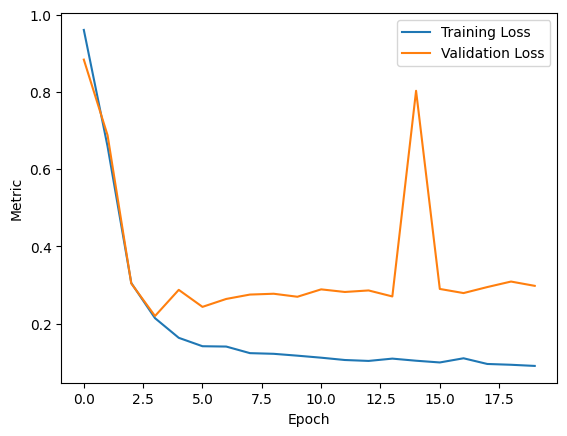

In [28]:

LectureModel = copy.deepcopy(lectureModel)
LectureHousingTrainer = Train_Model(LectureModel, nn.MSELoss(), torch.optim.SGD(LectureModel.parameters(), lr=0.01, momentum=0.9), nn.MSELoss(), "Regression",  device_to_use)

start_time = datetime.now()

LectureHousingTrainer.fit(trainLoaderHousing, validateLoaderHousing, 20)
end_time = datetime.now()

print("Time Taken to Train:", end_time - start_time)
### PLOTTING METRICS
plt.plot(LectureHousingTrainer.Metrics['Training_Loss'], label='Training Loss')
plt.plot(LectureHousingTrainer.Metrics['Validation_Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()

100%|██████████| 10/10 [00:00<00:00, 26.45it/s]


Current Epoch: 1
Training_Loss: 1.2695389091968536  | Validation_Loss: 0.9636016289393107


100%|██████████| 10/10 [00:00<00:00, 25.48it/s]


Current Epoch: 2
Training_Loss: 0.8156539767980575  | Validation_Loss: 0.7510230739911398


100%|██████████| 10/10 [00:00<00:00, 26.44it/s]


Current Epoch: 3
Training_Loss: 0.3555593937635422  | Validation_Loss: 0.45948346455891925


100%|██████████| 10/10 [00:00<00:00, 26.82it/s]


Current Epoch: 4
Training_Loss: 0.20536260157823563  | Validation_Loss: 0.4311381975809733


100%|██████████| 10/10 [00:00<00:00, 27.89it/s]


Current Epoch: 5
Training_Loss: 0.17564398050308228  | Validation_Loss: 0.2999156018098195


100%|██████████| 10/10 [00:00<00:00, 27.47it/s]


Current Epoch: 6
Training_Loss: 0.13571971282362938  | Validation_Loss: 0.3082946414748828


100%|██████████| 10/10 [00:00<00:00, 17.03it/s]


Current Epoch: 7
Training_Loss: 0.1132478654384613  | Validation_Loss: 0.2709523563583692


100%|██████████| 10/10 [00:00<00:00, 15.85it/s]


Current Epoch: 8
Training_Loss: 0.11832586973905564  | Validation_Loss: 0.26936668902635574


100%|██████████| 10/10 [00:00<00:00, 19.84it/s]


Current Epoch: 9
Training_Loss: 0.10961306616663932  | Validation_Loss: 0.28537289053201675


100%|██████████| 10/10 [00:00<00:00, 27.78it/s]


Current Epoch: 10
Training_Loss: 0.09914074912667274  | Validation_Loss: 0.8091374710202217


100%|██████████| 10/10 [00:00<00:00, 28.23it/s]


Current Epoch: 11
Training_Loss: 0.09984318129718303  | Validation_Loss: 0.26585271457831067


100%|██████████| 10/10 [00:00<00:00, 29.14it/s]


Current Epoch: 12
Training_Loss: 0.09086522832512856  | Validation_Loss: 0.2884744442999363


100%|██████████| 10/10 [00:00<00:00, 28.14it/s]


Current Epoch: 13
Training_Loss: 0.09282941073179245  | Validation_Loss: 0.3041554627319177


100%|██████████| 10/10 [00:00<00:00, 27.13it/s]


Current Epoch: 14
Training_Loss: 0.08433773554861546  | Validation_Loss: 0.2922684388856093


100%|██████████| 10/10 [00:00<00:00, 28.43it/s]


Current Epoch: 15
Training_Loss: 0.07250928301364183  | Validation_Loss: 0.24656474341948828


100%|██████████| 10/10 [00:00<00:00, 27.71it/s]


Current Epoch: 16
Training_Loss: 0.07020764015614986  | Validation_Loss: 0.26048634573817253


100%|██████████| 10/10 [00:00<00:00, 28.60it/s]


Current Epoch: 17
Training_Loss: 0.06922813318669796  | Validation_Loss: 0.244472769399484


100%|██████████| 10/10 [00:00<00:00, 27.05it/s]


Current Epoch: 18
Training_Loss: 0.07541052885353565  | Validation_Loss: 0.6737739543120066


100%|██████████| 10/10 [00:00<00:00, 28.58it/s]


Current Epoch: 19
Training_Loss: 0.061781161651015284  | Validation_Loss: 0.2410010633369287


100%|██████████| 10/10 [00:00<00:00, 29.04it/s]

Current Epoch: 20
Training_Loss: 0.07092189714312554  | Validation_Loss: 0.23333645363648733
Time Taken to Train: 0:00:10.044497


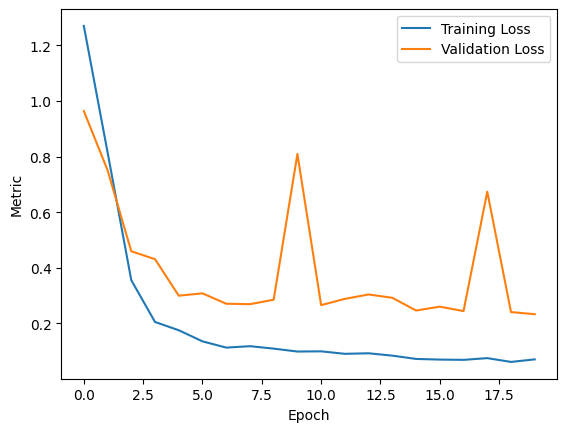

In [29]:
base_housingModel = copy.deepcopy(sale_predictor)
ComplexHousingTrainer = Train_Model(base_housingModel, nn.MSELoss(), torch.optim.SGD(base_housingModel.parameters(), lr=0.01, momentum=0.9), nn.MSELoss(), "Regression",  device_to_use)

start_time = datetime.now()

ComplexHousingTrainer.fit(trainLoaderHousing, validateLoaderHousing, 20)
end_time = datetime.now()

print("Time Taken to Train:", end_time - start_time)
### PLOTTING METRICS
plt.plot(ComplexHousingTrainer.Metrics['Training_Loss'], label='Training Loss')
plt.plot(ComplexHousingTrainer.Metrics['Validation_Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()

### What about training time and the comparison of model complexity?
When compared to the model constructed during the lectures in class, the new model exhibits more accuracy.
